
# LLM Fundamentals: A Brief Introduction
# Recurrent Neural Networks Basics

Language models started with RNNs - neural networks that process text one word at a time. Think of RNN as a reader that remembers what it read before. However, basic RNNs had memory problems with long texts, so better versions were created.

LSTM networks solved the memory problem by adding a system to remember important things and forget unimportant ones. GRU networks came later as a simpler version that works almost as well. These improvements made it possible to process longer texts effectively.

# Working with Sequences
Language models handle different sequence tasks. The simplest is predicting the next word, like your phone's keyboard suggestions. More complex tasks include translation, where text goes from one language to another, or summarization, where long text becomes short.
These tasks use an encoder-decoder structure. The encoder reads and understands the input, while the decoder creates the output. Modern models use attention - a technique that helps focus on relevant parts of the input, much like how humans focus on important parts of a sentence.

# Attention Mechanism
Core Idea
Attention lets a model focus on important parts of input when creating output. Like when you translate "The cat sat on the mat" - to translate 'cat' you mainly need to focus on the word 'cat', not other words. Attention does exactly this - it gives different importance weights to different input words.
How It Works
The process uses Query, Key, and Value - like searching a library:

Query: What you're looking for
Keys: Labels on information
Values: The actual information

The model matches Query with Keys to figure out which Values are important right now. It then combines the important parts to make its output.
Why It's Important
Before attention, models had to remember everything as they processed text one word at a time. With attention, models can directly look at any part of the input when needed - like having the whole text visible at once instead of reading through a keyhole.
This is why modern language models work so well - they can easily connect related words even if they're far apart in the text.

# Training
Training involves showing the model examples and letting it learn from mistakes. The process needs lots of data and computing power. Models learn by predicting next words and checking if they're right. This simple task actually teaches them grammar, facts, and reasoning.

Challenges include managing computer memory, keeping training stable, and making sure the model learns useful patterns. Modern LLMs use these same basic principles but at a much larger scale, which gives them their impressive capabilities.
# Training vs Fine-tuning Language Models
Pre-training
Pre-training is like giving the model general education. The model learns language by reading massive amounts of text from the internet, books, and articles. During this phase, it learns:

Basic language understanding
Grammar and vocabulary
General knowledge
Basic reasoning abilities

This process is extremely expensive. It requires:

Months of training time
Thousands of GPUs
Millions of dollars
Huge datasets (hundreds of billions of tokens)

Fine-tuning
Fine-tuning is like specialized training for a specific job. You take a pre-trained model and teach it specific skills or knowledge. It's much cheaper and faster than pre-training because:

Uses much less data (hundreds to thousands of examples)
Takes hours instead of months
Can run on a few GPUs or even one
Costs hundreds instead of millions of dollars

Common fine-tuning scenarios:

Teaching specific writing styles
Training for customer service
Learning company-specific knowledge
Following specific formats or rules

Key Differences
Think of pre-training as building a brain, while fine-tuning is teaching new skills to that brain:

Pre-training learns from scratch, fine-tuning adjusts existing knowledge
Pre-training is general, fine-tuning is specific
Pre-training needs massive resources, fine-tuning is lightweight
Pre-training builds foundation, fine-tuning adds specialization

When to Use What
Use pre-training when:

Building a new base model from scratch
Need completely new language capabilities
Have massive resources available


**Use fine-tuning when:**

Adapting existing model to specific tasks
Need consistent output format
Have limited resources
Want to add domain expertise


Installation of libraries

In [ ]:
!pip install torch numpy matplotlib pandas seaborn


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
def generate_sequence_data(samples=1000, sequence_length=20):

    x = np.linspace(0, 100, samples + sequence_length)
    y_pure = np.sin(0.1 * x)
    y_noisy = y_pure + np.random.normal(0, 0.1, len(x))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x[:200], y_pure[:200], 'b-', label='Pure Signal')
    plt.title('Original Sine Wave')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(x[:200], y_noisy[:200], 'r.', label='Noisy Data')
    plt.plot(x[:200], y_pure[:200], 'b-', alpha=0.3, label='Pure Signal')
    plt.title('Training Data (with Noise)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return y_noisy

In [ ]:
def create_sequences(data, seq_length):
    """Create input/output sequences"""
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class LSTMPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class GRUPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
def train_model(model, X_train, y_train, epochs=1000):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    losses = []
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

    return losses

In [ ]:
def plot_predictions(model, X, y, title):
    model.eval()
    with torch.no_grad():
        predictions = model(X).cpu().numpy()
        actual = y.cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.plot(actual[:100], 'b-', label='Actual', alpha=0.5)
    plt.plot(predictions[:100], 'r-', label='Predicted', alpha=0.5)
    plt.title(f'{title} - First 100 Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predictions

In [ ]:
print("Generating data...")
data = generate_sequence_data()
sequence_length = 20
X, y = create_sequences(data, sequence_length)

# Split data and convert to tensors
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to tensors
X_train = torch.FloatTensor(X_train).reshape(-1, sequence_length, 1).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).reshape(-1, sequence_length, 1).to(device)
y_test = torch.FloatTensor(y_test).to(device)


In [ ]:
print("\nInitializing models...")
models = {
    'RNN': SimpleRNN().to(device),
    'LSTM': LSTMPredictor().to(device),
    'GRU': GRUPredictor().to(device)
}

# Train all models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    losses = train_model(model, X_train, y_train)
    results[name] = losses

In [ ]:
plt.figure(figsize=(10, 6))
for name, losses in results.items():
    plt.plot(losses, label=name)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("\nGenerating predictions...")
for name, model in models.items():
    plot_predictions(model, X_test, y_test, name)

# Calculate and print MSE for each model
print("\nModel Performance (MSE):")
criterion = nn.MSELoss()
for name, model in models.items():
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test)
        mse = criterion(test_predictions, y_test)
        print(f"{name} MSE: {mse.item():.6f}")

print("\nTraining completed!")

1. Instruction Fine-tuning
Think of this as teaching the model to follow specific commands.
Best Use Cases:

Classification tasks
Information extraction
Structured output generation




Example Format:


```
    "instruction": "Extract the company names from this text",
    "input": "Apple and Microsoft announced a partnership today",
    "output": ["Apple", "Microsoft"]

```


Key Considerations:

Clear, consistent instructions
Well-defined output format
Quality of instruction examples

2. Chat Fine-tuning
Perfect for conversational applications.
Best Use Cases:

Customer service bots
Educational assistants
Interactive agents

Training Format:



```
{
    "messages": [
        {"role": "user", "content": "What's your return policy?"},
        {"role": "assistant", "content": "Our standard return window is 30 days..."},
        {"role": "user", "content": "What if the item is damaged?"},
        {"role": "assistant", "content": "For damaged items, we offer immediate replacement..."}
    ]
}
```




Key Points:

Conversation flow matters
Context handling is crucial
Role consistency is important

3. Text Completion
The simplest approach - completing or generating text.
Best For:

Code completion
Content generation
Text continuation

Format:


```
{
    "prompt": "def calculate_fibonacci(n):",
    "completion": "    if n <= 1:\n        return n\n    return calculate_fibonacci(n-1) + calculate_fibonacci(n-2)"
}
```




# Example - BLOOM Fine-tuning

In [ ]:
!pip install transformers datasets accelerate torch wandb
!pip install -q peft

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import matplotlib.pyplot as plt

In [ ]:
model_name = "bigscience/bloom-560m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)

In [ ]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
test_dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")



In [ ]:
def tokenize_function(examples):
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        max_length=128,
        padding="max_length",
        return_tensors="pt"
    )
    tokenized["labels"] = tokenized["input_ids"].clone()
    return tokenized



In [ ]:
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=dataset.column_names
)
test_tokenized = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=test_dataset.column_names
)

In [ ]:
training_args = TrainingArguments(
    output_dir="bloom-wiki-tuned",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    save_steps=500,
    logging_steps=100,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=test_tokenized
)


print("Starting training...")
train_result = trainer.train()

trainer.save_model()


plt.figure(figsize=(10, 5))
training_loss = [x["loss"] for x in trainer.state.log_history if "loss" in x]
plt.plot(training_loss)
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()


test_prompts = [
    "The history of Rome",
    "Quantum mechanics is",
    "The Industrial Revolution"
]

print("\nGeneration Examples:")
for prompt in test_prompts:
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        **inputs,
        max_length=100,
        num_return_sequences=1,
        temperature=0.7
    )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"\nPrompt: {prompt}")
    print(f"Generated: {generated_text}")

**Bloom Model fine tuning on custom data**


LoRA (Low-Rank Adaptation) is a technique to fine-tune large language models efficiently by freezing most of the model's weights and introducing small, trainable, low-rank matrices into the architecture.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensions of the original weight matrix
d_model = 256 # Model dimension
r = 4          # LoRA rank (low-rank adaptation)

# Original frozen weight matrix (W)
W = np.random.randn(d_model, d_model)

# Low-rank matrices (A and B)
A = np.random.randn(d_model, r)
B = np.random.randn(r, d_model)

# LoRA weight update (Delta W)
delta_W = np.dot(A, B)

# Updated weight matrix (W')
W_prime = W + delta_W

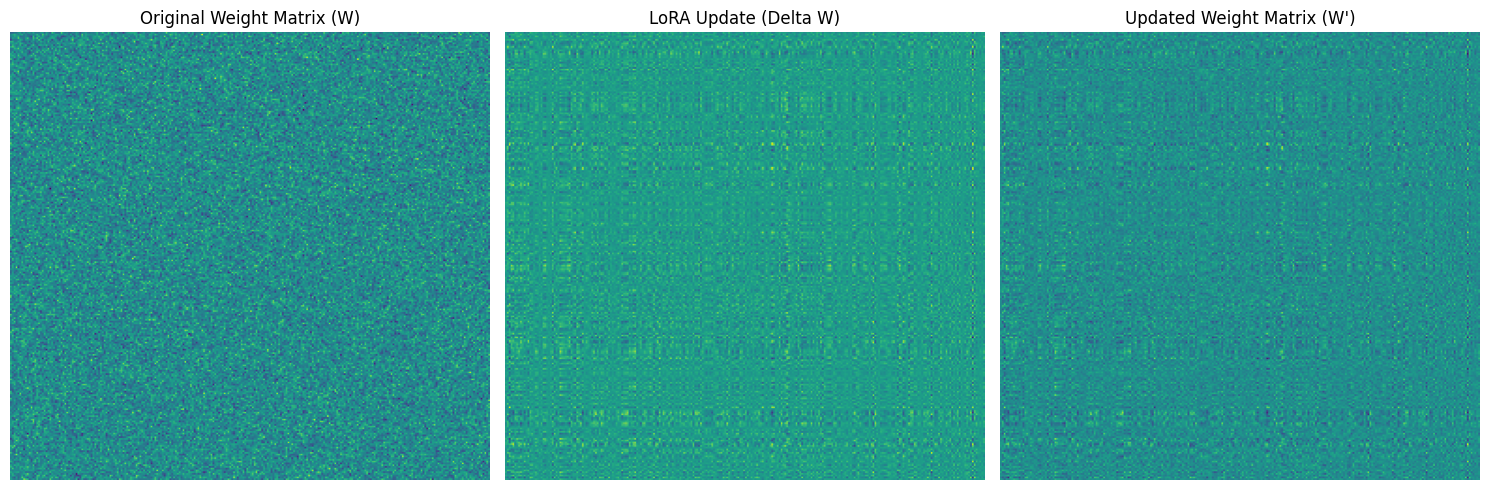

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))


axs[0].imshow(W, cmap='viridis', aspect='auto')
axs[0].set_title("Original Weight Matrix (W)")
axs[0].axis('off')


axs[1].imshow(delta_W, cmap='viridis', aspect='auto')
axs[1].set_title("LoRA Update (Delta W)")
axs[1].axis('off')


axs[2].imshow(W_prime, cmap='viridis', aspect='auto')
axs[2].set_title("Updated Weight Matrix (W')")
axs[2].axis('off')

plt.tight_layout()
plt.show()

Some examples of LoRA in math

In [1]:
import numpy as np

# Dimensions
d = 768  # Model dimension
r = 4    # Low-rank adaptation rank

# Frozen weight matrix (pre-trained)
W = np.random.randn(d, d)

# LoRA matrices
A = np.random.randn(d, r)
B = np.random.randn(r, d)

# Compute the low-rank update
alpha = 32  # Scaling factor
delta_W = (alpha / r) * np.dot(A, B)

# Updated weight matrix
W_prime = W + delta_W

print(f"Original W shape: {W.shape}")
print(f"Delta W shape: {delta_W.shape}")
print(f"Updated W' shape: {W_prime.shape}")

Original W shape: (768, 768)
Delta W shape: (768, 768)
Updated W' shape: (768, 768)


In [2]:
# Example input
x = np.random.randn(1, d)  # Single token representation

# Forward pass
y = np.dot(x, W_prime.T)  # Output after applying W'
print(f"Output shape: {y.shape}")

Output shape: (1, 768)


**Training the model Normal vs Lora**

In [ ]:
!pip install torch transformers datasets evaluate nltk

In [ ]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu


In [ ]:
file_path = "french.tsv"
df = pd.read_csv(file_path, sep='\t', header=None, names=["English", "French"])
train_df, valid_df = train_test_split(df, test_size=0.1, random_state=42)


In [ ]:
def save_to_jsonl(df, file_name):
    data = [{"source": row["English"], "target": row["French"]} for _, row in df.iterrows()]
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

save_to_jsonl(train_df, "train.json")
save_to_jsonl(valid_df, "valid.json")

data_files = {"train": "train.json", "validation": "valid.json"}
raw_datasets = load_dataset("json", data_files=data_files)


In [ ]:
model_name = "bigscience/bloom-560m"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    inputs = tokenizer(examples["source"], max_length=512, truncation=True)
    targets = tokenizer(examples["target"], max_length=512, truncation=True)
    return {"input_ids": inputs["input_ids"], "labels": targets["input_ids"]}

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)


In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name)

training_args = TrainingArguments(
    output_dir="./bloom-finetuned",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer
)

trainer.train()


In [ ]:
test_samples = valid_df.head(10)
for _, row in test_samples.iterrows():
    input_text = row["English"]
    reference = row["French"]

    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    output_ids = model.generate(input_ids, max_length=100)
    prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    score = sentence_bleu([reference.split()], prediction.split())
    print(f"Input: {input_text}")
    print(f"Reference: {reference}")
    print(f"Prediction: {prediction}")
    print(f"BLEU Score: {score}\n")

model.save_pretrained("./bloom-finetuned")
tokenizer.save_pretrained("./bloom-finetuned")

**Implement LoRA Fine-Tuning**

In [ ]:
!pip install torch transformers peft datasets evaluate bitsandbytes nltk

In [ ]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
file_path = "french.tsv"
df = pd.read_csv(file_path, sep='\t', header=None, names=["English", "French"])


train_df, valid_df = train_test_split(df, test_size=0.1, random_state=42)


def save_to_jsonl(df, file_name):
    data = [{"source": row["English"], "target": row["French"]} for _, row in df.iterrows()]
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

save_to_jsonl(train_df, "train.json")
save_to_jsonl(valid_df, "valid.json")

data_files = {"train": "train.json", "validation": "valid.json"}
raw_datasets = load_dataset("json", data_files=data_files)

In [ ]:
model_name = "bigscience/bloom-560m"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    inputs = tokenizer(examples["source"], max_length=512, truncation=True)
    targets = tokenizer(examples["target"], max_length=512, truncation=True)
    return {"input_ids": inputs["input_ids"], "labels": targets["input_ids"]}

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)


In [ ]:
from transformers import BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

from peft import LoraConfig, get_peft_model
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)


In [ ]:
model = get_peft_model(model, lora_config)

training_args = TrainingArguments(
    output_dir="./bloom-lora-finetuned",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer
)

trainer.train()


In [ ]:
test_samples = valid_df.head(10)
for _, row in test_samples.iterrows():
    input_text = row["English"]
    reference = row["French"]

    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    output_ids = model.generate(input_ids, max_length=100)
    prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    score = sentence_bleu([reference.split()], prediction.split())
    print(f"Input: {input_text}")
    print(f"Reference: {reference}")
    print(f"Prediction: {prediction}")
    print(f"BLEU Score: {score}\n")

model.save_pretrained("./bloom-lora-finetuned")
tokenizer.save_pretrained("./bloom-lora-finetuned")